## CRF Suite version

http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

from itertools import chain

from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import regex as re
from collections import namedtuple, defaultdict, Counter, OrderedDict
from IPython.display import display
from joblib import load, dump, Parallel, delayed

import os, string, sys

In [75]:
class RegexFeatures(object):
    PATTERNS = {
        "isInitCapitalWord": re.compile(r'^[A-Z][a-z]+'),
        "isAllCapitalWord": re.compile(r'^[A-Z][A-Z]+$'),
        "isAllSmallCase": re.compile(r'^[a-z]+$'),
        "isWord": re.compile(r'^[a-zA-Z][a-zA-Z]+$'),
        "isAlphaNumeric": re.compile(r'^\p{Alnum}+$'),
        "isSingleCapLetter": re.compile(r'^[A-Z]$'),
        "containsDashes": re.compile(r'.*--.*'),
        "containsDash": re.compile(r'.*\-.*'),
        "singlePunctuation": re.compile(r'^\p{Punct}$'),
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "singleDot": re.compile(r'[.]'),
        "singleComma": re.compile(r'[,]'),
        "singleQuote": re.compile(r'[\']'),
        "isSpecialCharacter": re.compile(r'^[#;:\-/<>\'\"()&]$'),
        "fourDigits": re.compile(r'^\d\d\d\d$'),
        "isDigits": re.compile(r'^\d+$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "containsDigit": re.compile(r'.*\d+.*'),
        "endsWithDot": re.compile(r'\p{Alnum}+\.$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@\p{Alnum}+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print "Initialized RegexFeature"
    @staticmethod
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features
    
    
def classification_report_to_df(report):
    report_list = []
    for i, line in enumerate(report.split("\n")):
        if i == 0:
            report_list.append(["class", "precision", "recall", "f1-score", "support"])
        else:
            line = line.strip()
            if line:
                if line.startswith("avg"):
                    line = line.replace("avg / total", "avg/total")
                line = re.split(r'\s+', line)
                report_list.append(tuple(line))
    return pd.DataFrame(report_list[1:], columns=report_list[0])


DATA_DIR="data/data/"
CLEANED_DIR="data/cleaned/"

Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if test_data:
                    assert len(line) == 1
                    line.append("?")
                if notypes:
                    line[1] = line[1][0]
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences


def load_vocab(filename):
    vocab = set()
    with open(filename) as fp:
        for line in fp:
            line = line.strip()
            vocab.add(line)
    return vocab      

    
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
        
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr)) 
        
        
def plot_cm(y_test, y_pred, labels=[]):
    labels_s = dict((k,i) for i,k in enumerate(labels))
    cm = np.zeros((len(labels), len(labels)))
    for i,j in zip(sum(y_test, []), sum(y_pred, [])):
        i = labels_s[i]
        j = labels_s[j]
        cm[i,j] += 1
    with plt.rc_context(rc={'xtick.labelsize': 12, 'ytick.labelsize': 12,
                       'figure.figsize': (16,14)}):
        sns.heatmap(cm * 100/ cm.sum(axis=1, keepdims=True),
                    #cmap=sns.cubehelix_palette(n_colors=100, rot=-.4, as_cmap=True),
                    cmap="Greys_r",
                    xticklabels=labels,
                    yticklabels=labels)
        plt.ylabel("True labels")
        plt.xlabel("Predicted labels")
    print cm.shape
    return cm


def print_sequences(sequences, predictions, filename, test_data=False):
    with open(filename, "wb+") as fp:
        for seq, pred in zip(sequences, predictions):
            for t, p in zip(seq, pred):
                token, tag = t
                if tag[0] == "U":
                    tag = "B%s" % tag[1:]
                if tag[0] == "E":
                    tag = "I%s" % tag[1:]
                if p[0] == "U":
                    p = "B%s" % p[1:]
                if p[0] == "E":
                    p = "I%s" % p[1:]
                if test_data:
                    line = "\t".join((token, p))
                else:
                    line = "\t".join((token, tag, p))
                print >> fp, line
            print >> fp, ""
    print "Done"

In [3]:
WORD_SPLITTER = re.compile(r'[\p{Punct}\s]+')
class DictionaryFeatures:
    def __init__(self, dictDir):
        self.word2dictionaries = {}
        self.word2hashtagdictionaries = {}
        self.dictionaries = []
        i = 0
        for d in os.listdir(dictDir):
            print >> sys.stderr, "read dict %s"%d
            self.dictionaries.append(d)
            if d == '.svn':
                continue
            for line in open(dictDir + "/" + d):
                word = line.rstrip('\n')
                word = word.strip(' ').lower()
                word_hashtag = "".join(WORD_SPLITTER.split(word))
                if not self.word2dictionaries.has_key(word):
                    self.word2dictionaries[word] = str(i)
                else:   
                    self.word2dictionaries[word] += "\t%s" % i
                if not self.word2hashtagdictionaries.has_key(word_hashtag):
                    self.word2hashtagdictionaries[word_hashtag] = str(i)
                else:
                    self.word2hashtagdictionaries[word_hashtag] += "\t%s" % i
            i += 1
    
    MAX_WINDOW_SIZE=6
    def GetDictFeatures(self, words, i):
        features = []
        for window in range(1,self.MAX_WINDOW_SIZE):
            start=max(i-window+1, 0)
            end = start + window
            phrase = ' '.join(words[start:end]).lower().strip(string.punctuation)
            if self.word2dictionaries.has_key(phrase):
                for j in self.word2dictionaries[phrase].split('\t'):
                    features.append('DICT=%s' % self.dictionaries[int(j)])
                if window > 1:
                    features.append('DICTWIN=%s' % window)
        return list(set(features))
    
    def GetHashtagDictFeatures(self, word):
        features = []
        if len(word) < 2 or word[0] != "#":
            return features
        word = word[1:].lower().strip(string.punctuation)
        if self.word2hashtagdictionaries.has_key(word):
            for j in self.word2hashtagdictionaries[word].split('\t'):
                features.append('DICT_HASHTAG=%s' % self.dictionaries[int(j)])
        return list(set(features))


In [60]:
dict_features = DictionaryFeatures("./data/cleaned/custom_lexicons/")

read dict time.holiday
read dict location.country
read dict award.award
read dict location
read dict movies.txt.results.txt
read dict lastname.5000
read dict sports.sports_team
read dict tv.tv_program
read dict book.newspaper
read dict internet.website
read dict base.events.festival_series
read dict products.txt.results.txt
read dict persons.txt.results.txt
read dict tv.tv_network
read dict cvg.computer_videogame
read dict business.consumer_product
read dict people.family_name
read dict tvshows.txt.results.txt
read dict government.government_agency
read dict venues
read dict broadcast.tv_channel
read dict music_artists.txt.results.txt
read dict automotive.make
read dict product
read dict business.consumer_company
read dict music_artists.txt
read dict venture_capital.venture_funded_company
read dict cvg.cvg_developer
read dict architecture.museum
read dict lower.5000
read dict automotive.model
read dict time.recurring_event
read dict cities.txt.results.txt
read dict sports.sports_league

In [48]:
def get_word_form(word, vocab=None, lower=False):
    if lower:
        word = word.lower()
    if vocab:
        vocab_search_word = word.lower() 
        word = "OOV" if vocab_search_word not in vocab else word
    return word    

def word2features(sent, widx, WORD_IDX=0, extra_features={},
                  vocab=None, dict_features=None,
                  vocab_presence_only=False,
                  dict_interactions=False,
                  interactions=False,
                  lowercase=True,
                  window=0,
                 verbose=False, dropout=0.5):
    word = sent[widx][WORD_IDX]
    features = {
        'bias': True,
        'word_normed': word.lower(),
        #'suffix_3': word[-3:].lower(),
        #'suffix_2': word[-2:].lower(),
        #'prefix_3': word[-3:].lower(),
        #'prefix_2': word[-2:].lower(),
    }
    if not lowercase:
        if np.random.rand() > dropout:
            features["word_original"] = word
    curr_word_normed = get_word_form(word, lower=lowercase)
    if widx > 0:
        prev_word = get_word_form(sent[widx-1][WORD_IDX], lower=lowercase)
        features["word[-1]"] = prev_word
        if interactions:
            if np.random.rand() > dropout:
                features["word[-1]=%s|word=%s" % (prev_word, curr_word_normed)] = True
    if widx < len(sent) -1:
        next_word = get_word_form(sent[widx+1][WORD_IDX], lower=lowercase)
        features["word[+1]"] = next_word
        if interactions:
            if np.random.rand() > dropout:
                features["word[+1]=%s|word=%s" % (next_word, curr_word_normed)] = True
    if vocab:
        if vocab_presence_only:
            features["word_normed"] = word.lower() in vocab
        else:
            features["word_normed"] = word.lower() if word.lower() in vocab else "OOV"
    regex_features = RegexFeatures.process(word)
    features.update(regex_features)
    if dict_features:
        d_features = dict_features.GetDictFeatures([k[WORD_IDX] for k in sent], widx)
        features.update({k: True for k in d_features})
        d_hashtag_features = dict_features.GetHashtagDictFeatures(word)
        features.update({k: True for k in d_hashtag_features})
    if window > 0:
        for i in range(max(widx-window, 0), widx):
            win_idx = i - widx
            d_features_w = dict_features.GetDictFeatures([k[WORD_IDX] for k in sent], i)
            if verbose and d_features_w:
                print i, widx, win_idx, sent[i], d_features_w
            features.update({"window[%s]_%s" % (win_idx, k): True for k in d_features_w})
            if dict_interactions:
                for kw in d_features:
                    if np.random.rand() > dropout:
                        features.update({"window[%s]_%s|word_%s" % (win_idx, k, kw): True for k in d_features_w})
        for i in range(widx + 1, min(widx+window+1, len(sent))):
            win_idx = i - widx
            d_features_w = dict_features.GetDictFeatures([k[WORD_IDX] for k in sent], i)
            if verbose and d_features_w:
                print i, widx, win_idx, sent[i], d_features_w
            features.update({"window[%s]_%s" % (win_idx, k): True for k in d_features_w})
            if dict_interactions:
                for kw in d_features:
                    if np.random.rand() > dropout:
                        features.update({"window[%s]_%s|word_%s" % (win_idx, k, kw): True for k in d_features_w})
    features.update(extra_features)
    if widx == 0:
        features['__BOS__'] = True
    if widx == len(sent)-1:
        features['__EOS__'] = True
    return features

def sent2features(sent, extra_features=None, **kwargs):
    if extra_features:
        return [word2features(sent, i, extra_features=extra_features[i],
                              **kwargs) for i in range(len(sent))]
    return [word2features(sent, i, **kwargs) for i in range(len(sent))]

def sent2labels(sent, lbl_id=1):
    return [k[lbl_id] for k in sent]

In [6]:
train_sequences = load_sequences("data/cleaned/train.BIEOU.tsv", sep="\t", notypes=False)
dev_sequences = (load_sequences("data/cleaned/dev.BIEOU.tsv", sep="\t", notypes=False) 
                 + load_sequences("data/cleaned/dev_2015.BIEOU.tsv", sep="\t", notypes=False))

vocab = load_vocab("vocab.no_extras.txt")
print len(vocab)

8023


In [61]:
%%time
upsampled_training_data = train_sequences*5
X_train = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False, lowercase=False, dropout=0.5)
           for s in upsampled_training_data]
y_train = [sent2labels(s) for s in upsampled_training_data]

X_test = [sent2features(s, vocab=None,
                        dict_features=dict_features, vocab_presence_only=False,
                        window=2, interactions=True, dict_interactions=False, lowercase=False, dropout=0)
          for s in dev_sequences]
y_test = [sent2labels(s) for s in dev_sequences]
print len(X_train), len(y_train), len(X_test), len(y_test)

11970 11970 1420 1420
CPU times: user 34 s, sys: 752 ms, total: 34.7 s
Wall time: 34.7 s


In [62]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='l2sgd', 
    c2=1e-3,
    #max_iterations=100,
    #calibration_samples=20,
    #all_possible_transitions=True,
    #all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 4min 20s, sys: 392 ms, total: 4min 20s
Wall time: 4min 20s


In [63]:
labels = list(crf.classes_)
labels.remove('O')
labels

['U-geo-loc',
 'B-facility',
 'E-facility',
 'B-movie',
 'E-movie',
 'U-company',
 'U-product',
 'U-person',
 'B-other',
 'E-other',
 'B-sportsteam',
 'E-sportsteam',
 'I-other',
 'B-product',
 'I-product',
 'E-product',
 'B-company',
 'E-company',
 'B-person',
 'E-person',
 'B-geo-loc',
 'E-geo-loc',
 'U-other',
 'I-facility',
 'U-sportsteam',
 'U-tvshow',
 'B-musicartist',
 'E-musicartist',
 'U-facility',
 'I-musicartist',
 'B-tvshow',
 'E-tvshow',
 'I-person',
 'U-musicartist',
 'I-geo-loc',
 'I-company',
 'I-movie',
 'U-movie',
 'I-tvshow',
 'I-sportsteam']

In [64]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)

y_pred = crf.predict(X_train)
print "Training accuracy: ", metrics.flat_f1_score(y_train, y_pred, 
                      average='weighted', labels=labels)

report = metrics.flat_classification_report(
    y_train, y_pred, labels=sorted_labels, digits=3
)
display(classification_report_to_df(report))

Training accuracy:  0.996547492717


,class,precision,recall,f1-score,support
0,B-company,0.993,1.000,0.996,135
1,E-company,0.993,1.000,0.996,135
2,I-company,1.000,1.000,1.000,45
3,U-company,0.990,0.997,0.994,720
4,B-facility,0.997,0.992,0.995,395
5,E-facility,0.997,0.992,0.995,390
6,I-facility,1.000,1.000,1.000,130
7,U-facility,0.985,0.992,0.989,130
8,B-geo-loc,0.987,1.000,0.993,225
9,E-geo-loc,0.985,1.000,0.993,200


In [65]:
y_pred = crf.predict(X_test)
print "Dev accuracy: ", metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

report = metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
)
display(classification_report_to_df(report))

Dev accuracy:  0.285857656202


,class,precision,recall,f1-score,support
0,B-company,0.000,0.000,0.000,27
1,E-company,0.000,0.000,0.000,27
2,I-company,0.000,0.000,0.000,14
3,U-company,0.519,0.311,0.389,45
4,B-facility,0.500,0.536,0.517,28
5,E-facility,0.414,0.444,0.429,27
6,I-facility,0.333,0.294,0.312,17
7,U-facility,0.000,0.000,0.000,18
8,B-geo-loc,0.400,0.341,0.368,41
9,E-geo-loc,0.531,0.472,0.500,36


In [66]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

Top likely transitions:
I-other -> E-other 9.738545
I-other -> I-other 9.497695
O      -> O       9.430610
B-other -> I-other 9.369440
B-person -> E-person 8.844218
B-facility -> E-facility 8.654766
B-other -> E-other 8.422605
B-musicartist -> E-musicartist 8.145564
I-facility -> E-facility 8.123712
B-product -> E-product 7.923859
B-company -> E-company 7.788056
B-facility -> I-facility 7.614000
B-musicartist -> I-musicartist 6.875702
I-musicartist -> E-musicartist 6.797822
B-sportsteam -> E-sportsteam 6.692585
I-person -> E-person 6.679926
B-movie -> I-movie 6.596718
I-movie -> E-movie 6.574521
B-product -> I-product 6.564891
I-product -> E-product 6.553286
B-geo-loc -> E-geo-loc 6.476547
B-tvshow -> E-tvshow 6.235243
B-movie -> E-movie 6.128637
I-product -> I-product 5.946696
O      -> U-person 5.879367


In [67]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(100))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-10:])

Top positive:
8.024072 U-person word_normed:pope
8.011719 U-other  word_normed:xmas
6.974464 U-facility word[-1]:at
6.962679 U-geo-loc DICT=location.country
6.417864 O        __BOS__
6.370821 U-person word_normed:ellwood
6.179657 U-person word_normed:jfk
6.127221 O        __EOS__
6.067341 U-other  word_normed:treasury
6.052094 U-person word_normed:pedersen
6.037460 U-facility word_normed:lhs
6.034076 U-other  DICT=sports.sports_league
5.942980 U-company word_normed:walmart
5.899255 U-person word_normed:beyonce
5.771144 U-other  word_normed:above&amp;beyond
5.712115 U-geo-loc word_normed:uk
5.534734 U-geo-loc word_normed:america
5.497369 U-company word_normed:target
5.465974 U-company word_normed:yahoo
5.436219 U-person word_normed:o.d.b.
5.360700 U-company word_normed:twitter
5.346324 U-other  word_normed:dems
5.335369 O        word_normed:september
5.261979 O        word_normed:saturday
5.240760 U-other  word_normed:a&amp;e
5.223121 U-geo-loc word_normed:alderwood
5.130850 U-company D

(41, 41)


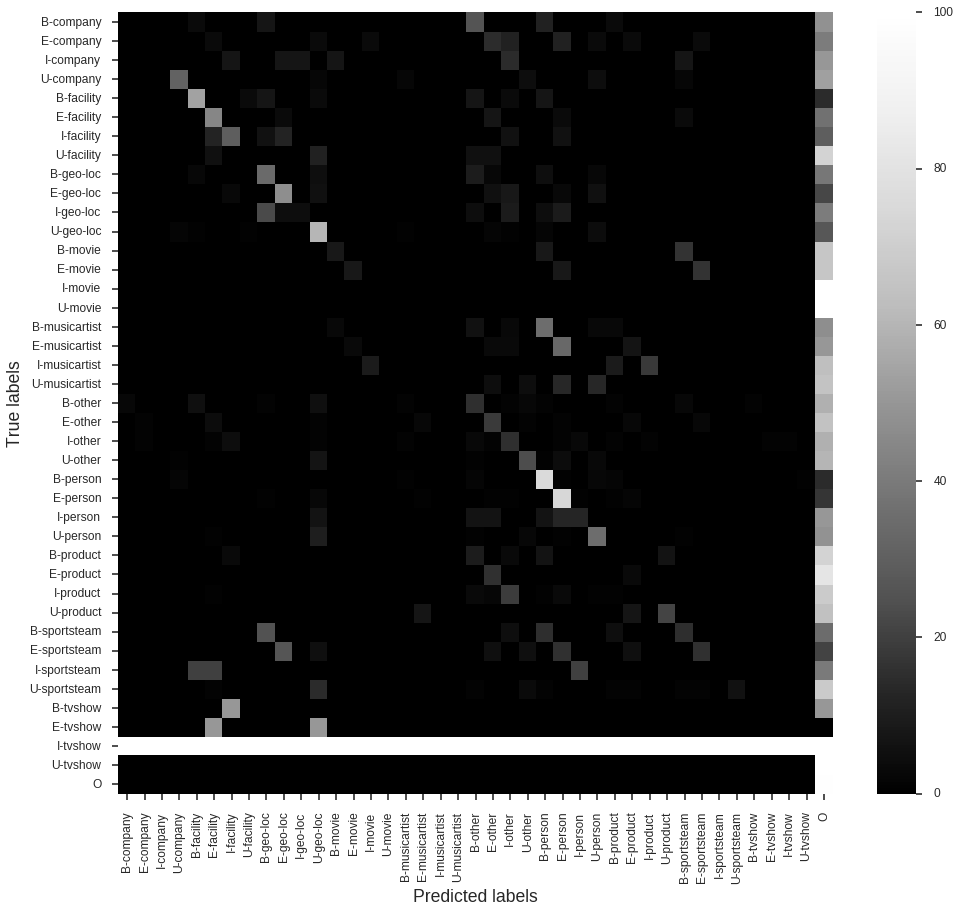

In [68]:
cm = plot_cm(y_test, y_pred, labels=sorted_labels + ["O"])

In [69]:
print_sequences(dev_sequences, y_pred, "dev.crf.bieou.tsv")

Done


In [71]:
## FINAL MODEL


! cat dev.crf.bieou.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 23050 tokens with 937 phrases; found: 670 phrases; correct: 291.
accuracy:  93.86%; precision:  43.43%; recall:  31.06%; FB1:  36.22
          company: precision:  48.28%; recall:  19.44%; FB1:  27.72  29
         facility: precision:  36.36%; recall:  26.09%; FB1:  30.38  33
          geo-loc: precision:  46.74%; recall:  53.09%; FB1:  49.71  184
            movie: precision:  16.67%; recall:   5.56%; FB1:   8.33  6
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
            other: precision:  30.25%; recall:  20.11%; FB1:  24.16  119
           person: precision:  53.04%; recall:  53.69%; FB1:  53.36  247
          product: precision:  14.29%; recall:   6.52%; FB1:   8.96  21
       sportsteam: precision:  40.00%; recall:   7.62%; FB1:  12.80  20
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  3


In [59]:
! cat dev.crf.bieou.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 23050 tokens with 937 phrases; found: 587 phrases; correct: 268.
accuracy:  94.06%; precision:  45.66%; recall:  28.60%; FB1:  35.17
          company: precision:  40.00%; recall:  19.44%; FB1:  26.17  35
         facility: precision:  37.04%; recall:  21.74%; FB1:  27.40  27
          geo-loc: precision:  50.00%; recall:  52.47%; FB1:  51.20  170
            movie: precision:  14.29%; recall:   5.56%; FB1:   8.00  7
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
            other: precision:  31.25%; recall:  16.76%; FB1:  21.82  96
           person: precision:  55.66%; recall:  48.36%; FB1:  51.75  212
          product: precision:  17.65%; recall:   6.52%; FB1:   9.52  17
       sportsteam: precision:  41.18%; recall:   6.67%; FB1:  11.48  17
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  1


In [92]:
! cat dev.crf.bieou.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 23050 tokens with 937 phrases; found: 420 phrases; correct: 196.
accuracy:  94.00%; precision:  46.67%; recall:  20.92%; FB1:  28.89
          company: precision:  78.57%; recall:  15.28%; FB1:  25.58  14
         facility: precision:  35.29%; recall:  13.04%; FB1:  19.05  17
          geo-loc: precision:  51.28%; recall:  37.04%; FB1:  43.01  117
            movie: precision:  50.00%; recall:   5.56%; FB1:  10.00  2
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
            other: precision:  18.97%; recall:   6.15%; FB1:   9.28  58
           person: precision:  51.50%; recall:  42.21%; FB1:  46.40  200
          product: precision:  25.00%; recall:   2.17%; FB1:   4.00  4
       sportsteam: precision:  42.86%; recall:   2.86%; FB1:   5.36  7
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  0


## Baseline score
```
==> data/result/4/dev.tsv.feats.SUMMARY <==
processed 23050 tokens with 933 phrases; found: 765 phrases; correct: 298.
accuracy:  93.80%; precision:  38.95%; recall:  31.94%; FB1:  35.10
          company: precision:  40.00%; recall:  19.44%; FB1:  26.17  35
         facility: precision:  18.37%; recall:  20.00%; FB1:  19.15  49
          geo-loc: precision:  46.82%; recall:  50.00%; FB1:  48.36  173
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  10
            other: precision:  32.82%; recall:  24.02%; FB1:  27.74  131
           person: precision:  45.36%; recall:  56.15%; FB1:  50.18  302
          product: precision:  13.16%; recall:  10.87%; FB1:  11.90  38
       sportsteam: precision:  47.06%; recall:   7.62%; FB1:  13.11  17
           tvshow: precision:  16.67%; recall:  12.50%; FB1:  14.29  6

```

## Submission

In [73]:
submission_sequences = load_sequences("data/test.txt", sep="\t", notypes=False, test_data=True) 

In [74]:
submission_sequences[0]

[Tag(token='New', tag='?'),
 Tag(token='Orleans', tag='?'),
 Tag(token='Mother', tag='?'),
 Tag(token="'s", tag='?'),
 Tag(token='Day', tag='?'),
 Tag(token='Parade', tag='?'),
 Tag(token='shooting', tag='?'),
 Tag(token='.', tag='?'),
 Tag(token='One', tag='?'),
 Tag(token='of', tag='?'),
 Tag(token='the', tag='?'),
 Tag(token='people', tag='?'),
 Tag(token='hurt', tag='?'),
 Tag(token='was', tag='?'),
 Tag(token='a', tag='?'),
 Tag(token='10-year-old', tag='?'),
 Tag(token='girl', tag='?'),
 Tag(token='.', tag='?'),
 Tag(token='WHAT', tag='?'),
 Tag(token='THE', tag='?'),
 Tag(token='HELL', tag='?'),
 Tag(token='IS', tag='?'),
 Tag(token='WRONG', tag='?'),
 Tag(token='WITH', tag='?'),
 Tag(token='PEOPLE', tag='?'),
 Tag(token='?', tag='?')]

In [76]:
X_submission = [sent2features(s, vocab=None,
                        dict_features=dict_features, vocab_presence_only=False,
                        window=2, interactions=True, dict_interactions=False, lowercase=False, dropout=0)
          for s in submission_sequences]
y_submission = [sent2labels(s) for s in submission_sequences]
print len(X_submission), len(y_submission)

3856 3856


In [77]:
y_pred_submission = crf.predict(X_submission)

In [80]:
print_sequences(submission_sequences, y_pred_submission,
                "Shubhanshu.DeepER.UIUC.WNUT_NER.10_types.txt",
                test_data=True,)

Done


## Testing

In [ ]:
dict_features.word2hashtagdictionaries["houseofcards"]

In [ ]:
found_seq=False
for seq in dev_sequences:
    for t in seq:
        if t.token == "#HouseofCards":
            found_seq = True
            break
    if found_seq:
        break
print seq

In [ ]:
seq_features = sent2features(seq, vocab=vocab,
                         dict_features=dict_features, vocab_presence_only=True, window=3, verbose=True)

    

In [ ]:
for i, (k,v) in enumerate(zip(seq, seq_features)):
    print "[%s]\t%s - %s:\n\t%s\n" % (i, k.token, k.tag, "\t".join(v.keys()))

In [ ]:
seq_features[17]